In [23]:
import requests
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import pandas as pd
import scipy

In [ ]:
token = 'eb8fc292-3478-495e-8335-cd842bcc4729'
mapID = 'faf7ef78-41b3-4a36-8423-688a61929c08'

headers = {"X-API-Key": f"{token}", "Content-Type": "applicaiton/json"}

response = requests.get(f'https://datsanta.dats.team/json/map/{mapID}.json')

In [ ]:
map = response.json()

gifts, snow_areas, childrens = map.values()

gifts_count = len(gifts) 
snow_areas_count = len(snow_areas) 
childrens_count = len(childrens) 

# gift properties: id, weight, volume
# snow_area properties: r, x, y
# children properties: x, y

In [26]:
def greedy_bin_packing(gifts): 
  stack_of_bags = []
  packed_gifts_count = 0
  
  gifts_packed = np.zeros(gifts_count, dtype=bool)

  while packed_gifts_count != gifts_count:
    bag = []
    bag_weight = 0
    bag_volume = 0

    for i in range(gifts_count):
      if gifts_packed[i]:
        continue

      potential_weight = bag_weight + gifts[i]['weight']
      potential_volume = bag_volume + gifts[i]['volume']

      if potential_weight <= 200 and potential_volume <= 100:
        bag_weight = potential_weight
        bag_volume = potential_volume 
        bag.append(gifts[i]['id'])
        
        gifts_packed[i] = True
        packed_gifts_count += 1

    stack_of_bags.append(bag)

  return stack_of_bags

In [27]:
def get_constraint(start, end):
    x1 = start['x']
    x2 = end['x']
    y1 = start['y']
    y2 = end['y']
    
    if x1 < x2 and y1 < y2:
        return 0
    
    if x1 > x2 and y1 > y2:
        return 1
    
    if x1 > x2 and y1 < y2:
        return 2
    
    if x1 < x2 and y1 > y2:
        return 3
    
    if x1 == x2 and y1 > y2:
        return 4
    
    if x1 == x2 and y1 < y2:
        return 5
    
    if x1 < x2 and y1 == y2:
        return 6
    
    if x1 > x2 and y1 == y2:
        return 7

In [28]:
def is_on_segment(start, end, intersection, constraint):
    x1 = start['x']
    x2 = end['x']
    y1 = start['y']
    y2 = end['y']
    x_point = intersection['x']
    y_point = intersection['y']
    
    if constraint == 0:
        if x1 <= x_point <= x2 and y1 <= y_point <= y2:
            return True
        
    elif constraint == 1:
        if x2 <= x_point <= x1 and y2 <= y_point <= y1:
            return True
        
    elif constraint == 2:
        if x2 <= x_point <= x1 and y1 <= y_point <= y2:
            return True
        
    elif constraint == 3:
        if x1 <= x_point <= x2 and y2 <= y_point <= y1:
            return True
        
    elif constraint == 4:
        if x_point == x1 and y2 <= y_point <= y1:
            return True
        
    elif constraint == 5:
        if x_point == x1 and y1 <= y_point <= y2:
            return True
        
    elif constraint == 6:
        if x1 <= x_point <= x2 and y_point == y1:
            return True
        
    elif constraint == 7:
        if x2 <= x_point <= x1 and y_point == y1:
            return True
            
    return False

In [29]:
def get_intersections(start, end, snow_area):
    x1 = start['x']
    x2 = end['x']
    y1 = start['y']
    y2 = end['y']
    x0 = snow_area['x']
    y0 = snow_area['y']
    r = snow_area['r']
    
    p = x2 - x1
    d = y2 - y1
    h = x1 * y2 - y1 * x2
    
    a = p**2 + d**2
    b = 2 * (p * (h - d * x0) - d**2 * y0)
    c = h * (h - 2 * d * x0) + d**2 * (x0**2 + y0**2 - r**2)
    
    D = b ** 2 - 4 * a * c
    
    intersections = []
    if D > 0:
        y_res1 = -(b + D**0.5) / (2 * a) 
        y_res2 = -(b - D**0.5) / (2 * a)
        
        x_res1 = (y_res1 * p + h) / d
        x_res2 = (y_res2 * p + h) / d
        
        intersection1 = {'x': x_res1, 'y': y_res1}
        intersection2 = {'x': x_res2, 'y': y_res2}
        
        constraint = get_constraint(start, end)
        
        if is_on_segment(start, end, intersection1, constraint):
            intersections.append(intersection1)
        
        if is_on_segment(start, end, intersection2, constraint):
            intersections.append(intersection2)
        
    return intersections

In [30]:
def get_distance(start, end):
  return ((end['x'] - start['x']) ** 2 + (end['y'] - start['y']) ** 2) ** 0.5

In [31]:
def get_time_distance(start, end):
    all_intersections = []
    time_distance = 0
    
    for snow_area in snow_areas:
        intersections = get_intersections(start, end, snow_area)
        
        if len(intersections) == 0:
            continue
            
        for intersection in intersections:   
            all_intersections.append(intersection)
            
    if len(all_intersections) == 0:
        return get_distance(start, end)
            
    all_intersections = sorted(all_intersections, key=lambda d: get_distance(start, d)) 
    
    points = all_intersections
    
    if start != points[0]:
        points = ([start] + points)
        
    if end != points[-1]:
        points.append(end)
    
    # смотрим, в каком круге (или ни в каком) находится стартовая точка
    
    start_area = {}
    slow_first = False
    for snow_area in snow_areas:
        x0 = snow_area['x']
        y0 = snow_area['y']
        r = snow_area['r']
        x1 = start['x']
        y1 = start['y']
        
        if (x1 - x0)**2 + (y1 - y0)**2 <= r**2:
            start_area = snow_area
            break
            
    if start_area != {}:
        x0 = start_area['x']
        y0 = start_area['y']
        r = start_area['r']
        x1 = start['x']
        y1 = start['y']

        if (x1 - x0)**2 + (y1 - y0)**2 < r**2:
            slow_first = True

        elif (x1 - x0)**2 + (y1 - y0)**2 == r**2:
            second_point = points[1]

            x_point = second_point['x']
            y_point = second_point['y']

            if (x_point - x0)**2 + (y_point - y0)**2 <= r**2:
                slow_first = True
            
    # начинаем обход sorted_intersections
    
    points_count = len(points)
    
    if slow_first:
        for i in range(points_count-1):
            distance = get_distance(points[i], points[i+1])
            
            if i % 2 == 0:
                time_distance += distance * 7
                
            else:
                time_distance += distance
                
    else:
        for i in range(points_count-1):
            distance = get_distance(points[i], points[i+1])
            
            if i % 2 == 1:
                time_distance += distance * 7
                
            else:
                time_distance += distance
                
    return time_distance

In [32]:
class Route():
  def __init__(self, moves):
      self.moves = moves
      self.length = Route.__calculate_length(moves)

  def __calculate_length(moves):
    moves_count = len(moves)
    route_length = get_distance({'x': 0, 'y': 0}, moves[0])

    for i in range(moves_count-1):
      route_length += get_time_distance(moves[i], moves[i+1])

    return route_length

In [33]:
def get_nearest_idx(current, childrens, visited):
  for j in range(childrens_count):
        if not visited[j]:
          min_distance = get_time_distance(current, childrens[j])
          min_idx = j
          break

  for k in range(childrens_count):
    if visited[k]:
      continue

    potential_distance = get_time_distance(current, childrens[k])

    if potential_distance < min_distance:
      min_distance = potential_distance
      min_idx = k

  return min_idx

In [34]:
def greedy_salesman(stack_of_bags, childrens):
  visited = np.zeros(childrens_count, dtype=bool)
  visited_count = 0

  moves = []
  current = {'x': 0, 'y': 0}
  bags_sizes = [len(bag) for bag in stack_of_bags]

  for bag_size in reversed(bags_sizes):
    for i in range(bag_size):
      nearest_idx = get_nearest_idx(current, childrens, visited)

      current = childrens[nearest_idx]
      visited[nearest_idx] = True
      moves.append(current)

    moves.append({'x': 0, 'y': 0})
    current = {'x': 0, 'y': 0}

  moves.pop(-1) 
   
  return Route(moves)

In [35]:
stack_of_bags = greedy_bin_packing(gifts)
stack_of_bags = sorted(stack_of_bags, reverse=True, key=len)

# for i, bag in enumerate(stack_of_bags):
#   print(f'{i}: {bag}')

In [36]:
bags_sizes = [len(bag) for bag in stack_of_bags]

# for i, bag_size in enumerate(bags_sizes):
#   print(f'{i}: {bag_size}')

In [37]:
route = greedy_salesman(stack_of_bags, childrens)
print(round(route.length), sep='\n')

1517115


In [38]:
moves = route.moves

x_moves = [move['x'] for move in moves]
y_moves = [move['y'] for move in moves]

x_moves = ([0] + x_moves)
y_moves = ([0] + y_moves)

x_childrens = [children['x'] for children in childrens]
y_childrens = [children['y'] for children in childrens]

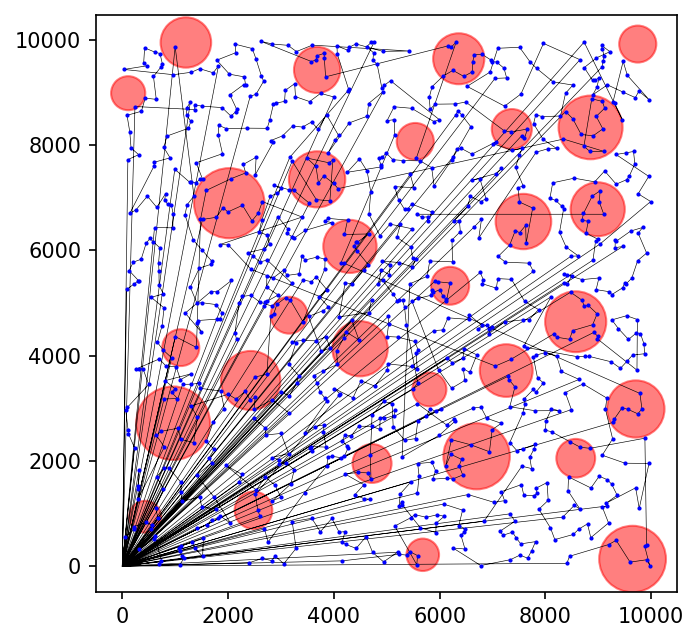

In [39]:
figure = plt.figure(figsize=(5, 5), dpi=150, facecolor='w', edgecolor='k')

for snow_area in snow_areas:
  plt.gca().add_artist(plt.Circle((snow_area['x'], snow_area['y']), radius=snow_area['r'], alpha=0.5, color='red', zorder=0))

plt.plot(x_moves, y_moves, color='black', linewidth=0.3, zorder=1)

plt.scatter(x_childrens, y_childrens, s=1, color='blue', zorder=2)

plt.show()

In [ ]:
figure = plt.figure(figsize=(5, 5), dpi=130, facecolor='w', edgecolor='k')
for snow_area in snow_areas:
      plt.gca().add_artist(plt.Circle((snow_area['x'], snow_area['y']), radius=snow_area['r'], alpha=0.5, color='red', zorder=0))

plt.scatter(x_childrens, y_childrens, s=1, color='blue', zorder=2)

# def animate(i):
#     plt.plot([x_moves[i], x_moves[i + 1]], [y_moves[i], y_moves[i + 1]], color='black', linewidth=0.3, zorder=1)
#     return figure

# anim = animation.FuncAnimation(figure, animate, frames=len(x_moves)-1, blit=False, repeat=False)

# anim

In [49]:
class ACO_TSP:  # класс алгоритма муравьиной колонии для решения задачи коммивояжёра
    def __init__(self, func, n_dim, size_pop=1000, max_iter=2, distance_matrix=None, alpha=1, beta=2, rho=0.1):
        self.func = func
        self.n_dim = n_dim  # количество городов
        self.size_pop = size_pop  # количество муравьёв
        self.max_iter = max_iter  # количество итераций
        self.alpha = alpha  # коэффициент важности феромонов в выборе пути
        self.beta = beta  # коэффициент значимости расстояния
        self.rho = rho  # скорость испарения феромонов
        self.distance_matrix = distance_matrix
        self.prob_matrix_distance = 1 / (distance_matrix + 1e-10 * np.eye(n_dim, n_dim))

        # Матрица феромонов, обновляющаяся каждую итерацию
        self.Tau = np.ones((n_dim, n_dim))
        # Путь каждого муравья в определённом поколении
        self.Table = np.zeros((size_pop, n_dim)).astype(int)
        self.y = None  # Общее расстояние пути муравья в определённом поколении
        self.generation_best_X, self.generation_best_Y = [], [] # фиксирование лучших поколений
        self.x_best_history, self.y_best_history = self.generation_best_X, self.generation_best_Y
        self.best_x, self.best_y = None, None

    def run(self, max_iter=None, distance_matrix = None):
        self.max_iter = max_iter or self.max_iter
        #self.distance_matrix = distance_matrix
        for i in range(self.max_iter):
            # вероятность перехода без нормализации
            prob_matrix = (self.Tau ** self.alpha) * (self.prob_matrix_distance) ** self.beta
            for j in range(self.size_pop):  # для каждого муравья
                # точка начала пути (она может быть случайной, это не имеет значения)
                self.Table[j, 0] = 0
                for k in range(self.n_dim - 1):  # каждая вершина, которую проходят муравьи
                    # точка, которая была пройдена и не может быть пройдена повторно
                    taboo_set = set(self.Table[j, :k + 1])
                    # список разрешённых вершин, из которых будет происходить выбор
                    allow_list = list(set(range(self.n_dim)) - taboo_set)
                    prob = prob_matrix[self.Table[j, k], allow_list]
                    prob = prob / prob.sum() # нормализация вероятности
                    next_point = np.random.choice(allow_list, size=1, p=prob)[0]
                    self.Table[j, k + 1] = next_point

            # рассчёт расстояния
            y = np.array([self.func(i, self.distance_matrix) for i in self.Table])

            # фиксация лучшего решения
            index_best = y.argmin()
            x_best, y_best = self.Table[index_best, :].copy(), y[index_best].copy()
            self.generation_best_X.append(x_best)
            self.generation_best_Y.append(y_best)

            # подсчёт феромона, который будет добавлен к ребру
            delta_tau = np.zeros((self.n_dim, self.n_dim))
            for j in range(self.size_pop):  # для каждого муравья
                for k in range(self.n_dim - 1):  # для каждой вершины
                    # муравьи перебираются из вершины n1 в вершину n2
                    n1, n2 = self.Table[j, k], self.Table[j, k + 1]
                    delta_tau[n1, n2] += 1 / y[j]  # нанесение феромона
                # муравьи ползут от последней вершины обратно к первой
                n1, n2 = self.Table[j, self.n_dim - 1], self.Table[j, 0]
                delta_tau[n1, n2] += 1 / y[j]  # нанесение феромона

            self.Tau = (1 - self.rho) * self.Tau + delta_tau

        best_generation = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[best_generation]
        self.best_y = self.generation_best_Y[best_generation]
        return self.best_x, self.best_y

    fit = run

In [42]:
def cal_total_distance(routine, distance_matrix):
    num_points, = routine.shape
    return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])

In [43]:
def ant_salesman(stack_of_bags, childrens):
  visited = np.zeros(childrens_count, dtype=bool)
  visited_count = 0

  moves = []
  current = {'x': 0, 'y': 0}
  bags_sizes = [len(bag) for bag in stack_of_bags]

  for bag_size in reversed(bags_sizes):
    childrens_by_bag = []

    for i in range(bag_size):
      nearest_idx = get_nearest_idx(current, childrens, visited)

      childrens_by_bag.append(childrens[nearest_idx])

      current = childrens[nearest_idx]
      visited[nearest_idx] = True

    num_points = bag_size + 1
    points_coordinate = np.zeros(num_points, dict)
    points_coordinate[0] = {'x' : 0, 'y' : 0}

    len_p = len(points_coordinate)

    for i in range(1, len_p):
      points_coordinate[i] = childrens_by_bag[i - 1]

    distance_matrix = np.zeros((num_points, num_points))
    num_of_columns = len(distance_matrix[i])

    for i in range(num_of_columns):
      for j in range(num_of_columns):
        distance_matrix[i][j] = get_time_distance(points_coordinate[i], points_coordinate[j])

    points = np.zeros((num_points, 2))

    for i in range(num_points):
      points[i] = [points_coordinate[i]['x'], points_coordinate[i]['y']]

    start_time = time.time() 

    aca = ACO_TSP(func=cal_total_distance, n_dim=num_points,
                  size_pop=60, 
                  max_iter=30, distance_matrix=distance_matrix)
    best_x, best_y = aca.run()
    
    best_points_ = np.concatenate([best_x, [best_x[0]]])
    best_points_coordinate = points[best_points_, :]
    len_b = len(best_points_coordinate)
    for i in range(1, len_b):
      moves.append({'x' : int(best_points_coordinate[i][0]), 'y': int(best_points_coordinate[i][1])})

    print("time of execution: %s seconds" %abs (time.time() - start_time))

    current = {'x': 0, 'y': 0}

  moves.pop(-1) 
   
  return Route(moves)

In [ ]:
route = ant_salesman(stack_of_bags, childrens)
# min_length = route.length

# best_route = route

# for i in range(4):
#     route = ant_salesman(stack_of_bags, childrens)
#     length = route.length
#     print(length)
    
#     if route.length < min_length:
#       min_length = route.length
#       best_route = route

# route = best_route

In [ ]:
print(route.length)

In [46]:
data = json.dumps({'mapID': f'{mapID}', 'moves': route.moves, 'stackOfBags': stack_of_bags})

In [ ]:
response_post = requests.post('https://datsanta.dats.team/api/round', data, headers=headers)

json_post = response_post.json()

roundId = json_post['roundId']

print(json_post)

In [ ]:
response_round = requests.get(f'https://datsanta.dats.team/api/round/{roundId}', headers=headers)

print(response_round.json())